In [50]:
import numpy as np
import models
import metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings("ignore")

# Carregando os dados

In [51]:
us_change = pd.read_csv('us_change.csv')
us_change

,Quarter,Consumption,Income,Production,Savings,Unemployment
0,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
1,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
2,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
3,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
4,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
193,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
194,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
195,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
196,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


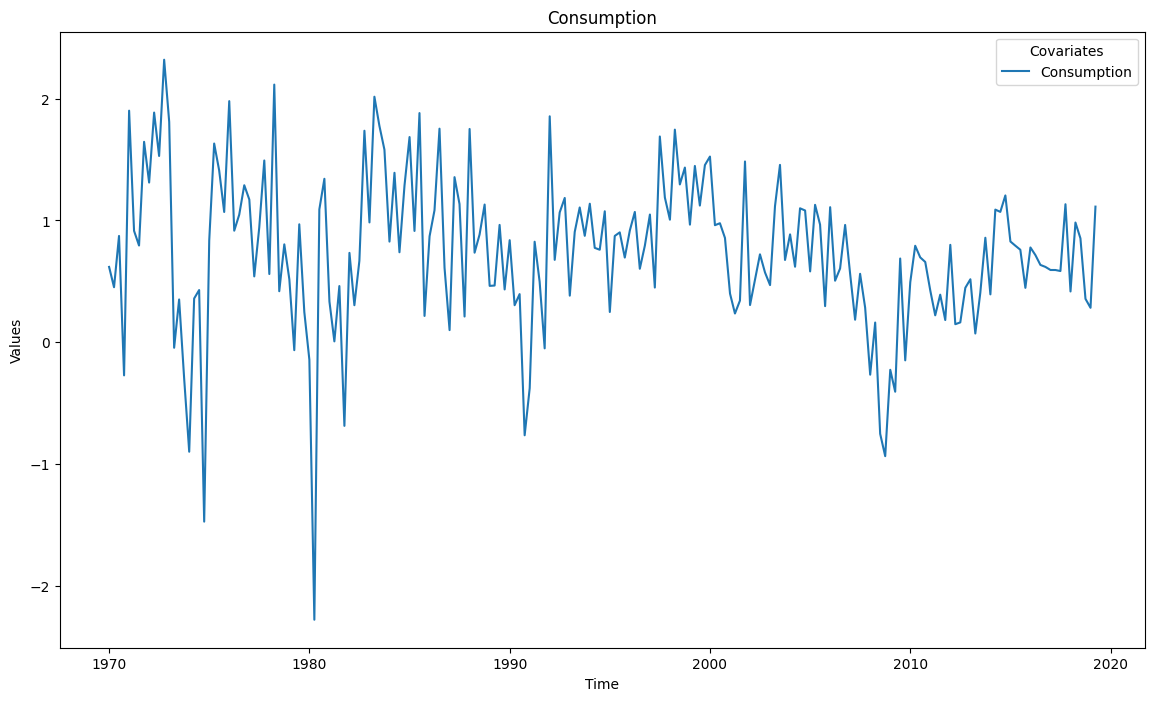

In [52]:
# Convert the 'Quarter' column to datetime format
def parse_quarter(quarter_str):
    year, quarter = quarter_str.split(' ')
    month = (int(quarter[1]) - 1) * 3 + 1
    return pd.Timestamp(f'{year}-{month:02d}-01')

us_change['Quarter'] = us_change['Quarter'].apply(parse_quarter)

# Set the 'Quarter' column as the index
us_change.set_index('Quarter', inplace=True)

# Plot all covariates as time series
plt.figure(figsize=(14, 8))
sns.lineplot(data=us_change['Consumption'], label='Consumption')
plt.title('Consumption')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend(title='Covariates')
plt.show()

In [53]:
us_change['Consumption'][:-12]

Quarter
1970-01-01    0.618566
1970-04-01    0.451984
1970-07-01    0.872872
1970-10-01   -0.271848
1971-01-01    1.901345
                ...   
2015-04-01    0.792813
2015-07-01    0.759427
2015-10-01    0.446824
2016-01-01    0.778254
2016-04-01    0.715591
Name: Consumption, Length: 186, dtype: float64

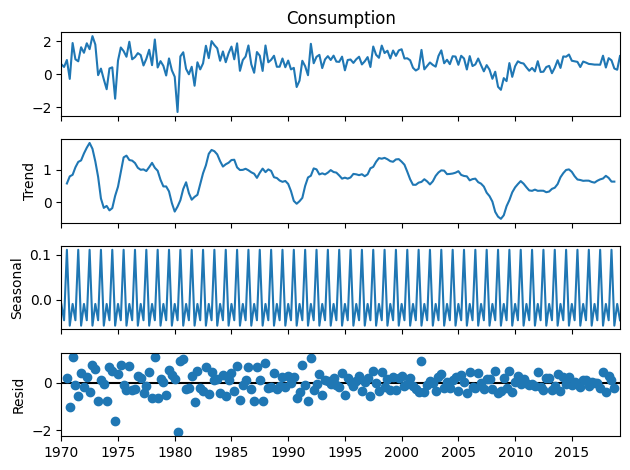

In [54]:
# Decompose the time series
decomposition = seasonal_decompose(us_change['Consumption'], model='additive')
decomposition.plot()
plt.show()

# Modelos SARIMA

In [55]:
consumption_train = us_change['Consumption'].iloc[:-12]
consumption_test = us_change['Consumption'].iloc[-12:]

arima = models.ARIMA(1, 1, 1)
arima.fit(consumption_train)

sarima = models.SARIMA(1, 1, 1, 1, 1, 1, 4)
sarima.fit(consumption_train)

predictions = pd.DataFrame({
    'ARIMA': arima.predict(12),
    'SARIMA': sarima.predict(12)
})

predictions

,ARIMA,SARIMA
2016-07-01,0.719699,0.875488
2016-10-01,0.719447,0.713061
2017-01-01,0.719462,0.748013
2017-04-01,0.719461,0.698612
2017-07-01,0.719461,0.868360
2017-10-01,0.719461,0.690742
2018-01-01,0.719461,0.751777
2018-04-01,0.719461,0.701204
2018-07-01,0.719461,0.870091
2018-10-01,0.719461,0.693802


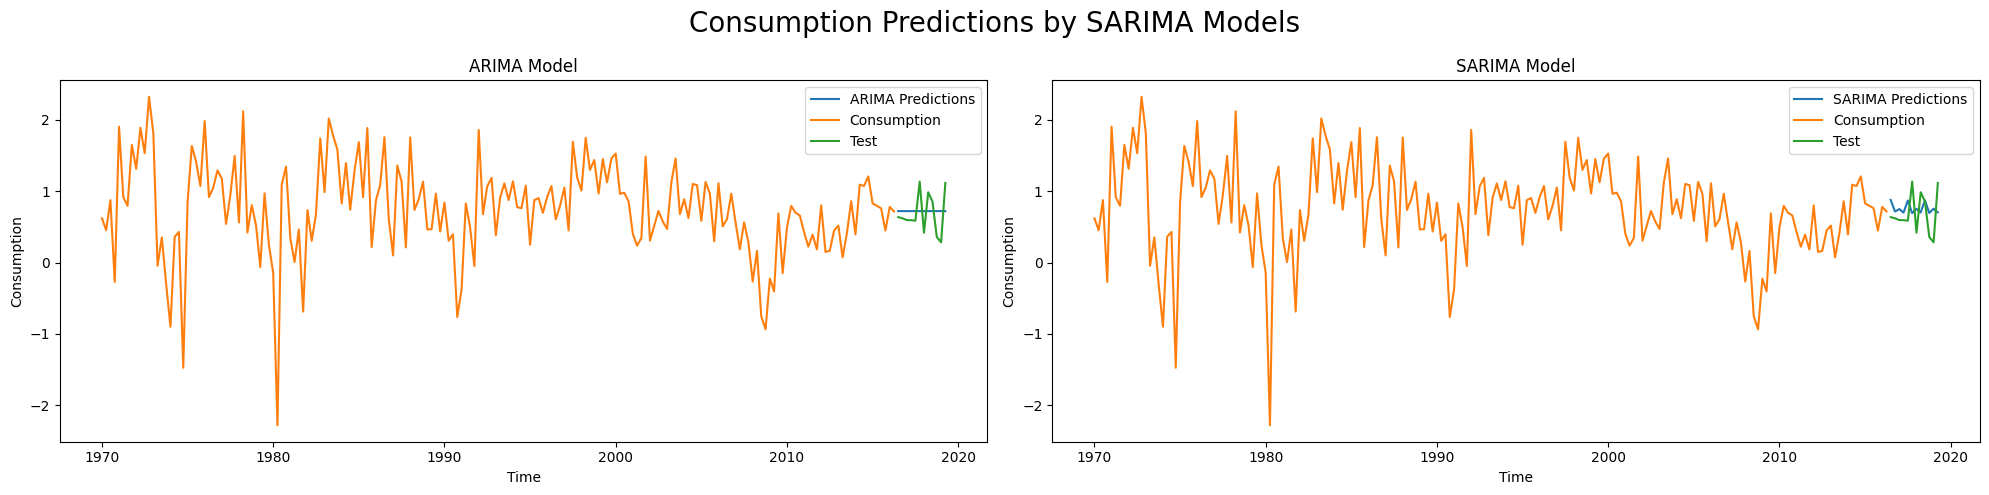

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=True)
fig.suptitle('Consumption Predictions by SARIMA Models', fontsize=20)
for ax, model in zip(axes.flatten(), predictions.columns):
    # Create a new series for the predictions
    prediction_series = pd.Series(predictions[model].values, 
                                  index=pd.date_range(start=consumption_train.index[-1], periods=12, freq='QE'))
    
    
    # Plot the prediction series
    sns.lineplot(data=prediction_series, ax=ax, label=f'{model} Predictions')
    
    #plot consumption data
    sns.lineplot(data=consumption_train, ax=ax, label='Consumption')
    sns.lineplot(data=consumption_test, ax=ax, label='Test')
    
    ax.set_title(f'{model} Model')
    ax.set_xlabel('Time')
    ax.set_ylabel('Consumption')

plt.tight_layout()
plt.show()

In [57]:
# Calculate metrics for each model
results = {}
for model in predictions.columns:
    y_pred = predictions[model].values
    y_true = consumption_test.values
    results[model] = {
        'MAE': metrics.mae(y_true, y_pred),
        'MSE': metrics.mse(y_true, y_pred),
        'RMSE': metrics.rmse(y_true, y_pred),
        'MAPE': metrics.mape(y_true, y_pred),
        'SMAPE': metrics.smape(y_true, y_pred),
        'R2': metrics.r2(y_true, y_pred),
        'MASE': metrics.mase(y_true, y_pred, consumption_train.values),
        'AIC': metrics.aic(y_true, y_pred, 2),
        'BIC': metrics.bic(y_true, y_pred, 2)   
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
results_df

,MAE,MSE,RMSE,MAPE,SMAPE,R2,MASE,AIC,BIC
ARIMA,0.239998,0.074585,0.273103,44.860650,35.847057,-0.021000,0.422326,-27.149736,-26.179923
SARIMA,0.264439,0.089459,0.299097,49.425502,38.832489,-0.224604,0.465335,-24.967719,-23.997905


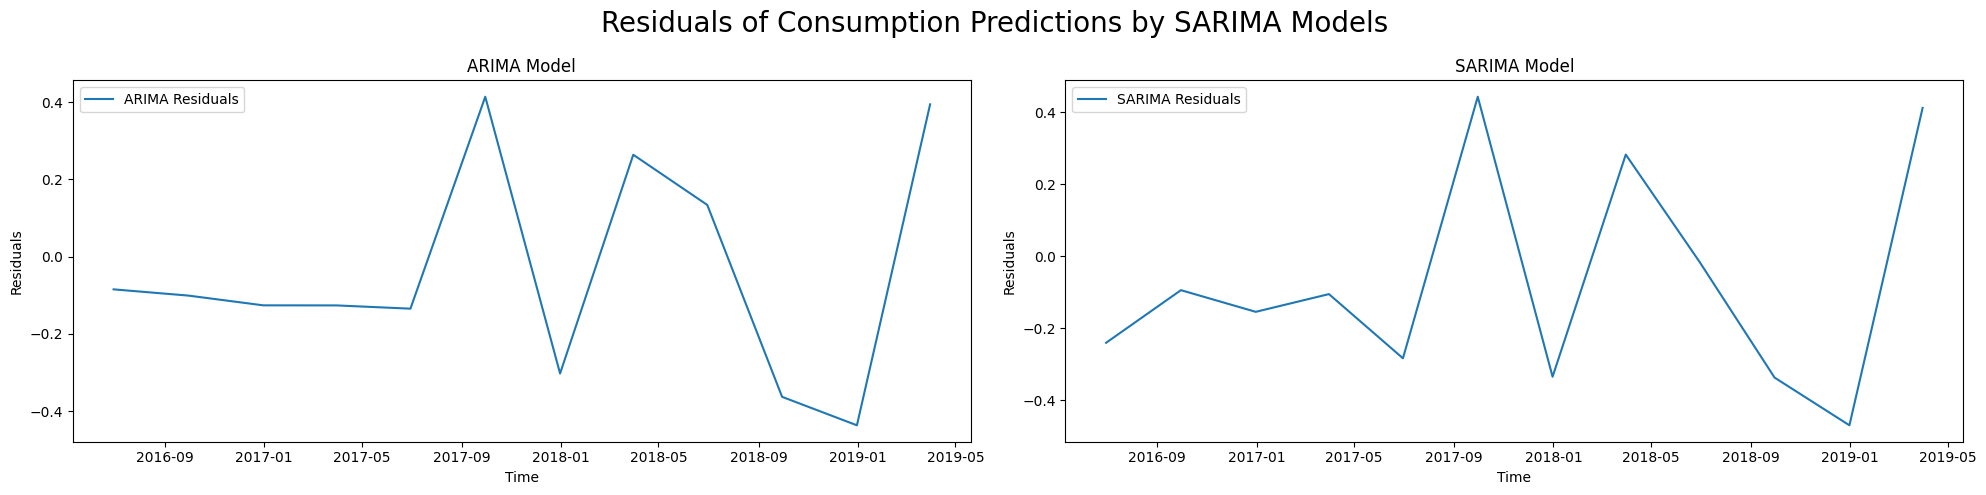

In [58]:
# Calculate the residuals for each model
residuals = {}
for model in predictions.columns:
    y_pred = predictions[model].values
    y_true = consumption_test.values
    residuals[model] = y_true - y_pred

# Plot the residuals
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharex=True)
fig.suptitle('Residuals of Consumption Predictions by SARIMA Models', fontsize=20)
for ax, model in zip(axes.flatten(), residuals.keys()):
    # Create a new series for the residuals
    residual_series = pd.Series(residuals[model], 
                                index=pd.date_range(start=consumption_train.index[-1], periods=12, freq='QE'))
    
    # Plot the residuals series
    sns.lineplot(data=residual_series, ax=ax, label=f'{model} Residuals')
    
    ax.set_title(f'{model} Model')
    ax.set_xlabel('Time')
    ax.set_ylabel('Residuals')
    
plt.tight_layout()
plt.show()

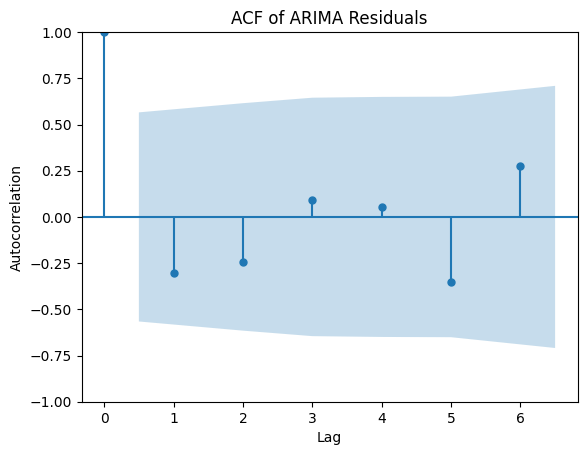

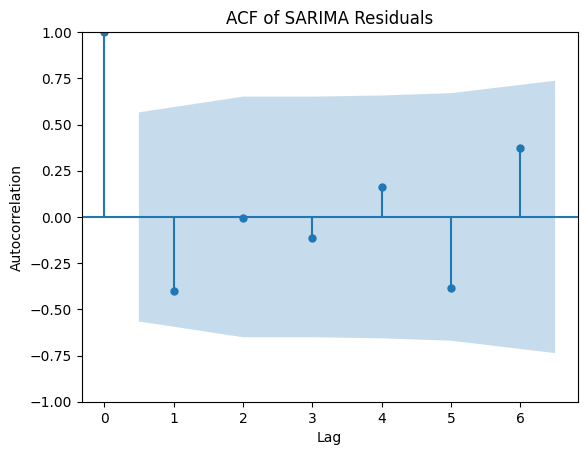

In [59]:
for residual in residuals:
    plot_acf(residuals[residual])
    plt.title(f'ACF of {residual} Residuals')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()